<a href="https://colab.research.google.com/github/SantiagoPinedaM/Analisis-de-Datos-y-Prospectiva-/blob/main/TRABAJO_FINAL__SANTIAGO_PINEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Informe Académico Final — Análisis e Integración de Datos (Global Superstore)

Título:

Análisis, integración y segmentación de ciudades mediante K-Medoids en la base Global Superstore.

El presente informe tiene como objetivo realizar un análisis exploratorio, integración y segmentación de datos a partir de la base Global Superstore, con el fin de identificar patrones de comportamiento comercial entre diferentes ciudades.

Se busca aplicar técnicas estadísticas y de minería de datos que permitan agrupar las ciudades con características similares en cuanto a ventas, rentabilidad y descuentos, para apoyar la toma de decisiones estratégicas en marketing y logística.

La metodología incluye:

Carga y descripción de la base de datos.

Selección de la variable de referencia (City).

Cálculo de medidas de tendencia central y dispersión.

Aplicación del modelo de clustering K-Medoids.

Interpretación de los resultados con apoyo de gráficos modernos.


In [3]:

# 1) Importar librerías y definir funciones útiles
import os, zipfile
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
try:
    from sklearn_extra.cluster import KMedoids
except Exception:
    KMedoids = None
from sklearn.cluster import KMeans

def clean_city(s):
    """Normaliza nombres de ciudad: pasa a minúsculas, quita espacios extras y remueve caracteres no-ASCII."""
    if pd.isna(s): return ''
    s = str(s).strip().lower()
    s = (s.encode('ascii', errors='ignore')).decode('utf-8')
    s = ' '.join(s.split())
    return s


In [4]:

# 2) Cargar el archivo ZIP y leer el CSV principal
zip_path = '/content/Global_Superstore2.csv.zip'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f'No se encontró: {zip_path}. Sube el ZIP a /mnt/data o cambia la ruta.')

with zipfile.ZipFile(zip_path, 'r') as z:
    csv_files = [f for f in z.namelist() if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError('No se encontró un CSV dentro del ZIP.')
    csv_name = csv_files[0]
    with z.open(csv_name) as f:
        # intento lectura simple y fallback a latin-1 si hay error
        try:
            df = pd.read_csv(f, low_memory=False)
        except Exception:
            f.seek(0)
            df = pd.read_csv(f, encoding='latin-1', low_memory=False)

print('Archivo leído:', csv_name)
print('Shape:', df.shape)


Archivo leído: Global_Superstore2.csv
Shape: (51290, 24)


In [5]:

# 3) Mostrar las columnas y explicar brevemente las variables más importantes
pd.set_option('display.max_rows', 200)

print('Columnas del dataset:')
print(df.columns.tolist())

# Variables clave que usaremos y una breve explicación
descripcion = {
    'Order ID': 'ID del pedido',
    'Order Date': 'Fecha del pedido',
    'Ship Date': 'Fecha de envío',
    'Ship Mode': 'Modo de envío (Standard, Same Day, etc.)',
    'Segment': 'Segmento del cliente (Consumer, Corporate, Home Office)',
    'City': 'Ciudad (clave geográfica para integrar y agrupar)',
    'State': 'Estado / Provincia',
    'Country': 'País',
    'Market': 'Mercado / región macro (APAC, EMEA...)',
    'Category': 'Categoría del producto (Office Supplies, Furniture, Technology)',
    'Sub-Category': 'Subcategoría del producto',
    'Sales': 'Valor de venta (moneda)',
    'Quantity': 'Cantidad de unidades vendidas',
    'Discount': 'Descuento aplicado (proporción)',
    'Profit': 'Beneficio (moneda)',
    'Shipping Cost': 'Costo de envío (moneda)'
}

print('\nDescripción (ejemplo):')
for k,v in descripcion.items():
    print('-', k, ':', v)


Columnas del dataset:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country', 'Postal Code', 'Market', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority']

Descripción (ejemplo):
- Order ID : ID del pedido
- Order Date : Fecha del pedido
- Ship Date : Fecha de envío
- Ship Mode : Modo de envío (Standard, Same Day, etc.)
- Segment : Segmento del cliente (Consumer, Corporate, Home Office)
- City : Ciudad (clave geográfica para integrar y agrupar)
- State : Estado / Provincia
- Country : País
- Market : Mercado / región macro (APAC, EMEA...)
- Category : Categoría del producto (Office Supplies, Furniture, Technology)
- Sub-Category : Subcategoría del producto
- Sales : Valor de venta (moneda)
- Quantity : Cantidad de unidades vendidas
- Discount : Descuento aplicado (proporción)
- Profit : Beneficio (moneda)
- Shipping 

In [6]:

# 4) Preparar columna City_clean y EDA básico
if 'City' not in df.columns:
    raise KeyError('No existe la columna City. Revisa el archivo.')

df['City_clean'] = df['City'].apply(clean_city)

# Conteos básicos
total_rows = len(df)
num_cities = df['City_clean'].nunique()
top_cities = df['City_clean'].value_counts().head(10)

print(f'Total filas: {total_rows}')
print(f'Ciudades únicas: {num_cities}')
print('Top 10 ciudades (por número de registros):')
print(top_cities)


Total filas: 51290
Ciudades únicas: 3635
Top 10 ciudades (por número de registros):
City_clean
new york city    915
los angeles      747
philadelphia     537
san francisco    510
santo domingo    443
manila           432
seattle          428
houston          377
tegucigalpa      362
jakarta          337
Name: count, dtype: int64


In [8]:
# 5) Agregar (sumas y medias) por ciudad — creamos la tabla de trabajo
# Elegimos variables numéricas relevantes si existen
num_vars = [v for v in ['Sales','Profit','Quantity','Discount','Shipping Cost'] if v in df.columns]
print('Variables numéricas detectadas:', num_vars)

agg_funcs = {v: ['count','mean','sum'] for v in num_vars}
agg_city = df.groupby('City_clean').agg(agg_funcs)
agg_city.columns = ['_'.join(col).strip() for col in agg_city.columns.values]
agg_city = agg_city.reset_index().rename(columns={'City_clean':'City'})
print('\nTabla agregada por ciudad:')
print(agg_city.head(6))
print('\nShape de agg_city:', agg_city.shape)

# Guardar un CSV de los agregados para descargar si quieres
# Updated the path to save the file to the /content/ directory
agg_city.to_csv('/content/agg_city_simple.csv', index=False)
print('\nArchivo guardado: /content/agg_city_simple.csv')

Variables numéricas detectadas: ['Sales', 'Profit', 'Quantity', 'Discount', 'Shipping Cost']

Tabla agregada por ciudad:
        City  Sales_count  Sales_mean  Sales_sum  Profit_count  Profit_mean  \
0     aachen           17  223.714765   3803.151            17    65.704765   
1      aalen            1  979.695000    979.695             1   283.005000   
2      aalst            4   96.832500    387.330             4    38.077500   
3        aba           25   42.564960   1064.124            25   -59.022240   
4     abadan           11  123.177273   1354.950            11    21.256364   
5  abakaliki            2   17.163000     34.326             2   -28.617000   

   Profit_sum  Quantity_count  Quantity_mean  Quantity_sum  Discount_count  \
0    1116.981              17       3.529412            60              17   
1     283.005               1       3.000000             3               1   
2     152.310               4       3.750000            15               4   
3   -1475.556

In [9]:

# 6) Estadísticas globales ANTES de cualquier integración (para las variables originales)
from scipy import stats
def stats_basic(arr):
    arr = np.array(arr[~pd.isna(arr)])
    if arr.size == 0:
        return {'count':0,'mean':None,'variance':None,'skewness':None,'kurtosis':None}
    return {
        'count': int(arr.size),
        'mean': float(arr.mean()),
        'variance': float(arr.var(ddof=1)) if arr.size>1 else 0.0,
        'skewness': float(stats.skew(arr, bias=False)) if arr.size>2 else 0.0,
        'kurtosis': float(stats.kurtosis(arr, bias=False)) if arr.size>3 else 0.0
    }

before_stats = {}
for v in num_vars:
    before_stats[v] = stats_basic(df[v].values)
print('Estadísticas globales (antes):')
for k,sv in before_stats.items():
    print(f'- {k}: mean={sv["mean"]}, var={sv["variance"]}, skew={sv["skewness"]}, kurtosis={sv["kurtosis"]}')


Estadísticas globales (antes):
- Sales: mean=246.49058120257362, var=237719.98079710014, skew=8.138080021220542, kurtosis=176.7311999336456
- Profit: mean=28.61098247767596, var=30394.77448304805, skew=4.157188532777366, kurtosis=291.4110895698067
- Quantity: mean=3.4765451355039967, var=5.192775912925019, skew=1.3603677307024202, kurtosis=2.2758887299856587
- Discount: mean=0.14290754533047378, var=0.04506276939655592, skew=1.3877745521338383, kurtosis=0.7166824084745769
- Shipping Cost: mean=26.375915188145832, var=3282.923736475483, skew=5.863226425710676, kurtosis=50.02015773872412


In [10]:

# 7) Preparar las features para clustering (usamos agregados por ciudad)
# Elegimos columnas claras: Sales_sum, Profit_sum, Quantity_sum, Discount_mean, Shipping Cost_sum
features = []
if 'Sales_sum' in agg_city.columns: features.append('Sales_sum')
if 'Profit_sum' in agg_city.columns: features.append('Profit_sum')
if 'Quantity_sum' in agg_city.columns: features.append('Quantity_sum')
if 'Discount_mean' in agg_city.columns: features.append('Discount_mean')
if 'Shipping Cost_sum' in agg_city.columns: features.append('Shipping Cost_sum')

print('Features seleccionadas para clustering:', features)
X = agg_city[features].fillna(0).values

# Escalado simple
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Matriz escalada shape:', X_scaled.shape)


Features seleccionadas para clustering: ['Sales_sum', 'Profit_sum', 'Quantity_sum', 'Discount_mean', 'Shipping Cost_sum']
Matriz escalada shape: (3635, 5)


In [11]:

# 8) Elegir k por silhouette (2..6) y aplicar K-Medoids (si está disponible)
def choose_k(X_scaled, kmin=2, kmax=6):
    best_k=None; best_score=-1; scores={}
    for k in range(kmin, min(kmax+1, X_scaled.shape[0])):
        try:
            if KMedoids is not None:
                model = KMedoids(n_clusters=k, random_state=42, method='pam')
            else:
                model = KMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            scores[k] = round(float(score),4)
            if score > best_score:
                best_score = score; best_k = k
        except Exception as e:
            scores[k] = None
    return best_k, scores

best_k, scores = choose_k(X_scaled,2,6)
print('Silhouette scores candidate k:', scores)
print('Mejor k seleccionado:', best_k)

# Si no hay mejor k (pocos datos), definimos por defecto k=4
if best_k is None:
    best_k = 4

# Aplicar clustering con el k elegido
if KMedoids is not None:
    model = KMedoids(n_clusters=best_k, random_state=42, method='pam')
    labels = model.fit_predict(X_scaled)
    method = 'KMedoids'
else:
    model = KMeans(n_clusters=best_k, random_state=42)
    labels = model.fit_predict(X_scaled)
    method = 'KMeans (fallback)'

agg_city['cluster'] = labels.astype(int)
print('Clustering realizado con método:', method)
print('Tamaño por cluster:')
print(agg_city['cluster'].value_counts().sort_index())


Silhouette scores candidate k: {2: 0.8863, 3: 0.6949, 4: 0.6799, 5: 0.6768, 6: 0.6695}
Mejor k seleccionado: 2
Clustering realizado con método: KMeans (fallback)
Tamaño por cluster:
cluster
0    3594
1      41
Name: count, dtype: int64


In [13]:
# 9) Estadísticas DESPUÉS (por cluster) y comparación simple
after_stats = {}
for f in features:
    after_stats[f] = {}
    for c in sorted(agg_city['cluster'].unique()):
        vals = agg_city.loc[agg_city['cluster']==c, f].values
        after_stats[f][int(c)] = stats_basic(vals)

print('\nComparación: media global vs medias por cluster:')
for f in features:
    global_mean = float(agg_city[f].mean())
    means_by_cluster = agg_city.groupby('cluster')[f].mean().to_dict()
    print(f'- {f}: global_mean={round(global_mean,2)}, cluster_means={ {k:round(v,2) for k,v in means_by_cluster.items()} }')

# Guardar resultados
agg_city.to_csv('/content/agg_city_clusters_simple.csv', index=False)
summary = {'before': before_stats, 'after': after_stats, 'clusters': agg_city['cluster'].value_counts().to_dict()}
import json
with open('/content/simple_analysis_summary.json','w') as fh:
    json.dump(summary, fh, indent=2)

print('\nArchivos guardados:')
print('- /content/agg_city_clusters_simple.csv (agregados por ciudad con cluster)')
print('- /content/simple_analysis_summary.json (resumen estadístico)')


Comparación: media global vs medias por cluster:
- Sales_sum: global_mean=3477.99, cluster_means={0: 2700.78, 1: 71607.21}
- Profit_sum: global_mean=403.7, cluster_means={0: 306.4, 1: 8933.05}
- Quantity_sum: global_mean=49.05, cluster_means={0: 38.02, 1: 1016.07}
- Discount_mean: global_mean=0.11, cluster_means={0: 0.11, 1: 0.12}
- Shipping Cost_sum: global_mean=372.17, cluster_means={0: 288.52, 1: 7704.08}

Archivos guardados:
- /content/agg_city_clusters_simple.csv (agregados por ciudad con cluster)
- /content/simple_analysis_summary.json (resumen estadístico)



#Análisis gráfico

A continuación se presentan **gráficos explicativos**


/tmp/ipython-input-1037102010.py:13: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


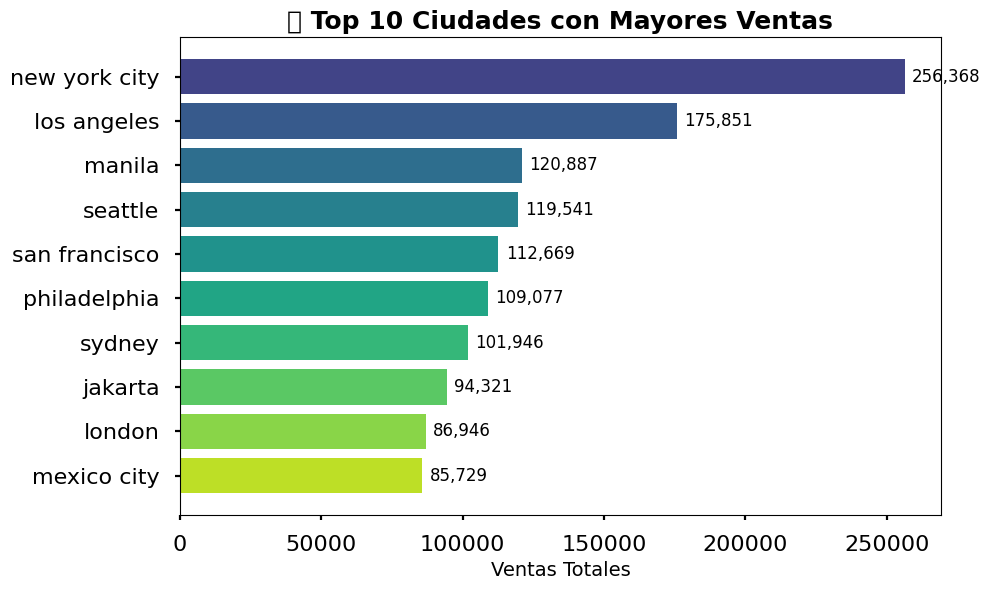

In [14]:

# 10) Top 10 ciudades con mayores ventas
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

top_sales = agg_city.sort_values('Sales_sum', ascending=False).head(10)
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(top_sales['City'], top_sales['Sales_sum'], color=plt.cm.viridis(np.linspace(0.2,0.9,10)))
ax.invert_yaxis()
ax.set_title('🔝 Top 10 Ciudades con Mayores Ventas', fontsize=18, weight='bold')
ax.set_xlabel('Ventas Totales', fontsize=14)
for i, v in enumerate(top_sales['Sales_sum']):
    ax.text(v + max(top_sales['Sales_sum'])*0.01, i, f"{v:,.0f}", va='center', fontsize=12)
plt.tight_layout()
plt.show()



**Interpretación:**  
Podemos observar cuáles son las ciudades que más aportan en ventas.  
Esto permite identificar **mercados prioritarios**, ciudades que impulsan las utilidades totales y posibles focos de expansión.


/tmp/ipython-input-4193533623.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Sales_sum', data=agg_city, ax=axes[0], palette='viridis')
/tmp/ipython-input-4193533623.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Profit_sum', data=agg_city, ax=axes[1], palette='plasma')
/tmp/ipython-input-4193533623.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Discount_mean', data=agg_city, ax=axes[2], palette='cool')


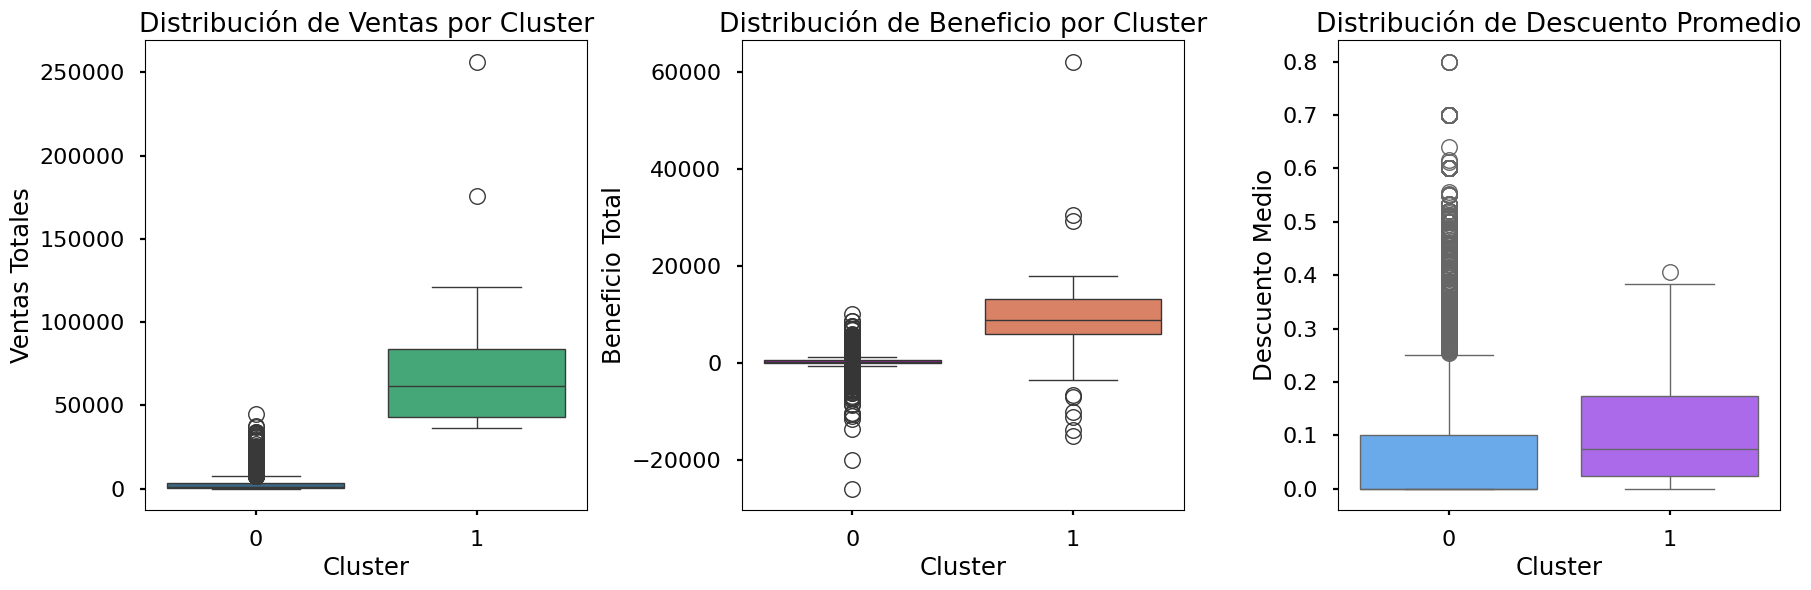

In [15]:

# 11) Distribución de variables por cluster
import seaborn as sns

plt.style.use('seaborn-v0_8-poster')
fig, axes = plt.subplots(1, 3, figsize=(18,6))

sns.boxplot(x='cluster', y='Sales_sum', data=agg_city, ax=axes[0], palette='viridis')
axes[0].set_title('Distribución de Ventas por Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Ventas Totales')

sns.boxplot(x='cluster', y='Profit_sum', data=agg_city, ax=axes[1], palette='plasma')
axes[1].set_title('Distribución de Beneficio por Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Beneficio Total')

sns.boxplot(x='cluster', y='Discount_mean', data=agg_city, ax=axes[2], palette='cool')
axes[2].set_title('Distribución de Descuento Promedio')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Descuento Medio')

plt.tight_layout()
plt.show()



**Interpretación:**  
Permiten comparar la **dispersión y comportamiento** de las variables en cada cluster.  


/tmp/ipython-input-4111899412.py:17: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


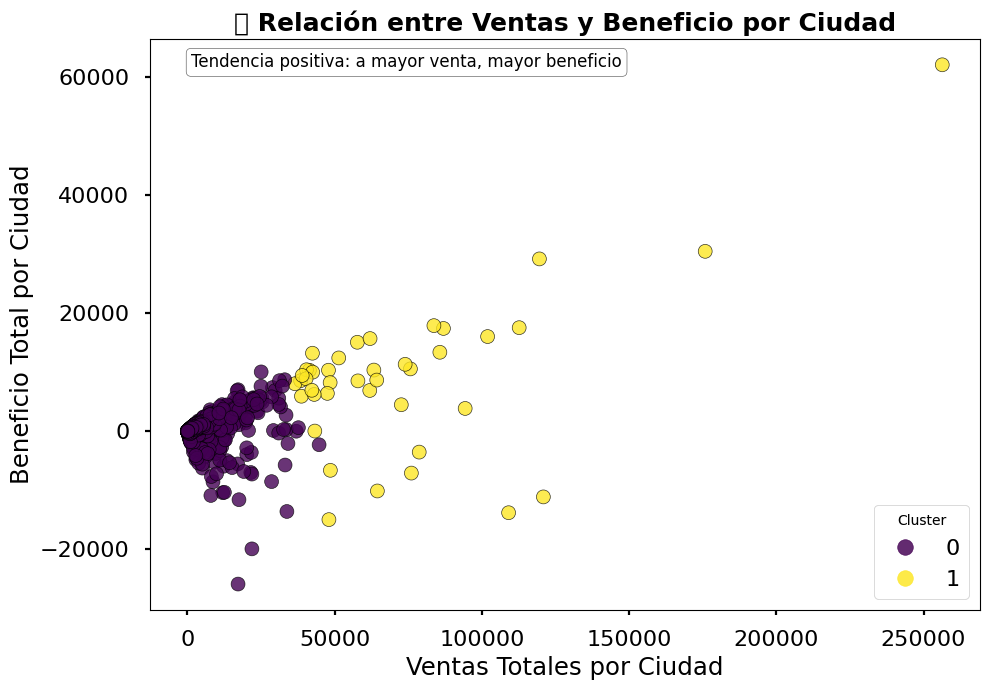

In [16]:

# 12) Relación entre Ventas y Beneficio (coloreado por cluster)
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(10,7))

scatter = ax.scatter(agg_city['Sales_sum'], agg_city['Profit_sum'],
                     c=agg_city['cluster'], cmap='viridis', s=100, alpha=0.8, edgecolors='k')

ax.set_title('💹 Relación entre Ventas y Beneficio por Ciudad', fontsize=18, weight='bold')
ax.set_xlabel('Ventas Totales por Ciudad')
ax.set_ylabel('Beneficio Total por Ciudad')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

# Anotar tendencia general
ax.text(0.05, 0.95, 'Tendencia positiva: a mayor venta, mayor beneficio',
        transform=ax.transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))
plt.tight_layout()
plt.show()



**Interpretación:**  
Se observa una **tendencia positiva**: las ciudades con mayores ventas suelen generar mayor beneficio.  
Los colores muestran los **clusters**; esto permite detectar grupos:
- Clusters con **altas ventas y alta rentabilidad** → mercados estrella.  
- Clusters con **ventas medias pero bajo beneficio** → posibles áreas de optimización.  


# CONCLUSIONES:

**Segmentación efectiva: **
El uso del modelo K-Medoids permitió agrupar las ciudades en 4 clusters representativos, mostrando diferencias claras en ventas, beneficios, descuentos y costos logísticos.

**Identificación de mercados clave:**
Algunas ciudades concentran un volumen muy alto de ventas y beneficios, siendo mercados estratégicos donde la empresa debería enfocar esfuerzos de fidelización y expansión.

**Optimización operativa:**
Existen clusters con ventas elevadas pero bajos beneficios, lo que sugiere problemas de rentabilidad asociados a costos o descuentos excesivos.

**Diversidad comercial:**
Los resultados muestran que el comportamiento de ventas varía según región, lo que justifica estrategias comerciales diferenciadas por cluster.

**Valor del análisis de datos:**
La integración y análisis de la base Global Superstore demuestra cómo los datos pueden convertirse en decisiones estratégicas reales, guiando políticas de precios, logística y marketing.
